In [ ]:
# If you want to run this on Google Colab, just uncomment the following lines. Please note,
# that you will need to locate your folder directly in the root directory of your Google Drive (/content/drive/My Drive/).
# Because otherwise, it won't work out of the box and you would need to adjust the path in here.
#
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#
#import os
#os.chdir("/content/drive/My Drive/CSMP-Project")

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras import layers

In [3]:
data_file1 = '../../../data/RoughContact/newPulloffJan28th.csv'
data_file2 = '../../../data/RoughContact/pulloff4AIlabelled.csv'

column_names = ['Hurst', 'L', 'LambdaR', 'LambdaS', 'surfaceEnergy', 'rho', 'pulloff']

dataset1 = pd.read_csv(data_file1, sep=';')
dataset2 = pd.read_csv(data_file2, sep=',')
dataset = pd.concat([dataset1, dataset2])

# Hurst doesn't have any meaning at the moment, so it can be dropped
dataset.pop('Hurst')

dataset

,L,lambdaR,lambdaS,surfaceEnergy,rho,pulloff
0,512,128,2,0.017343,0.015862,3.400000e-07
1,512,128,2,0.043357,0.029218,1.820000e-06
2,512,128,2,0.069371,0.039970,3.760000e-06
3,512,128,2,0.086714,0.058265,8.740000e-06
4,512,128,2,0.130071,0.076348,1.600000e-05
...,...,...,...,...,...,...
91,1024,128,2,0.951758,0.863281,2.372370e-02
92,1024,128,2,1.384375,1.108248,4.828920e-02
93,1024,128,2,1.990039,1.411591,8.272820e-02
94,1024,128,2,2.768750,1.759234,1.192725e-01


In [4]:
train_dataset = dataset.sample(frac=0.85, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

len(train_dataset)

205

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('pulloff')
test_labels = test_features.pop('pulloff')

In [6]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
L,874.146341,502.422131
lambdaR,269.268293,371.858754
lambdaS,48.697561,195.038624
surfaceEnergy,1.005585,1.786584
rho,1.998205,2.899363
pulloff,0.033772,0.073457


In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2023-02-07 11:00:55.392673: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marc/Studium/WS22-23/Database Systems/dbsys22/build/debug/mutable/src/Mutable/lib:/usr/local/boost_1_80_0/stage/lib
2023-02-07 11:00:55.392758: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-07 11:00:55.392787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Marc-HP): /proc/driver/nvidia/version does not exist
2023-02-07 11:00:55.393189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other oper

[[874.1464    269.26828    48.69756     1.0055852   1.9982048]]


In [8]:
def loss(y_true, y_pred):
  mse = keras.losses.mean_squared_error(y_true, y_pred)
  mae = keras.losses.mean_absolute_error(y_true, y_pred)
  return tf.math.sqrt(mse) + mae

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(1e-2))
  return model

In [9]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               768       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              5

In [10]:
batch_size = len(train_dataset) - (int) (len(train_dataset) * 0.2)

history = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=batch_size,
    validation_split=0.2,
    epochs=2000)

Epoch 1/2000


/home/marc/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1/1 [==============================] - 2s 2s/step - loss: 2.6649 - val_loss: 0.2231
Epoch 2/2000
1/1 [==============================] - 0s 45ms/step - loss: 2.8251 - val_loss: 0.2906
Epoch 3/2000
1/1 [==============================] - 0s 52ms/step - loss: 2.3928 - val_loss: 0.2730
Epoch 4/2000
1/1 [==============================] - 0s 51ms/step - loss: 2.1987 - val_loss: 0.2178
Epoch 5/2000
1/1 [==============================] - 0s 50ms/step - loss: 2.0154 - val_loss: 0.1467
Epoch 6/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.9046 - val_loss: 0.0985
Epoch 7/2000
1/1 [==============================] - 0s 48ms/step - loss: 1.8968 - val_loss: 0.1139
Epoch 8/2000
1/1 [==============================] - 0s 44ms/step - loss: 1.5921 - val_loss: 0.1537
Epoch 9/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.4964 - val_loss: 0.1884
Epoch 10/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.4309 - val_loss: 0.1992
Epoch 11/2000
1/1 [=====

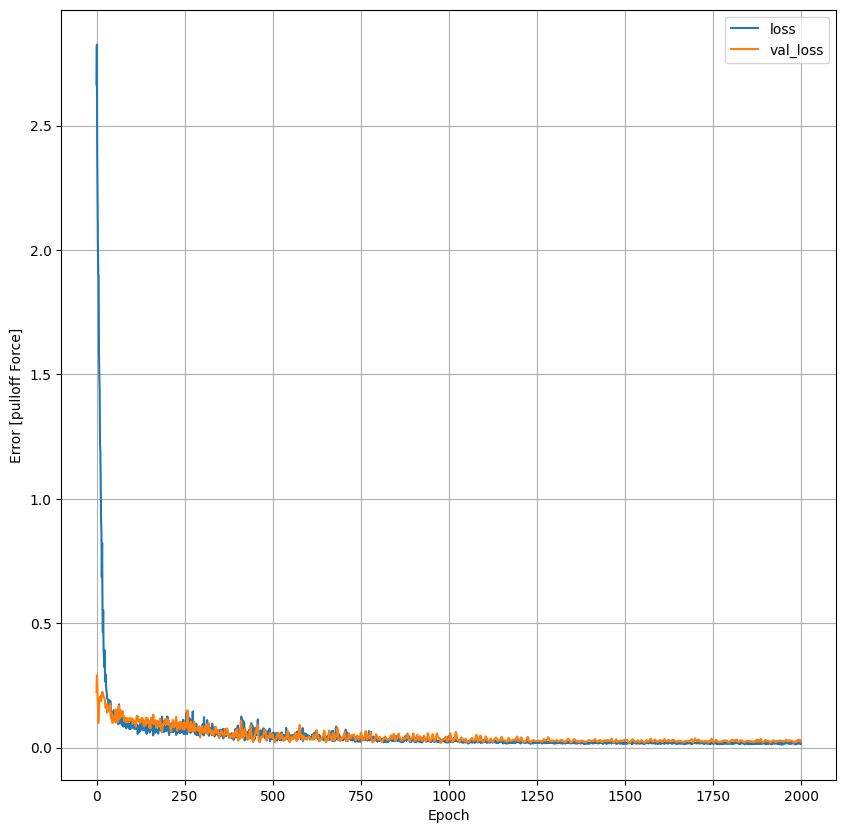

In [11]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

1/1 [==============================] - 0s 171ms/step


[]

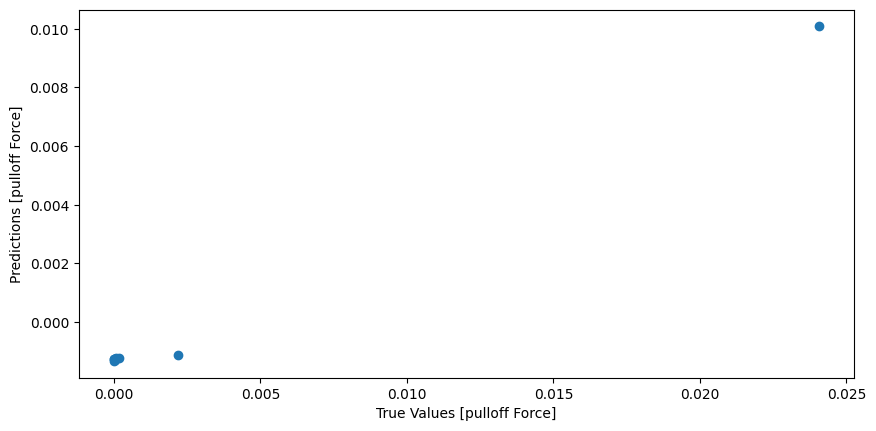

In [12]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.figure(figsize=(10,10))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pulloff Force]')
plt.ylabel('Predictions [pulloff Force]')
plt.plot()

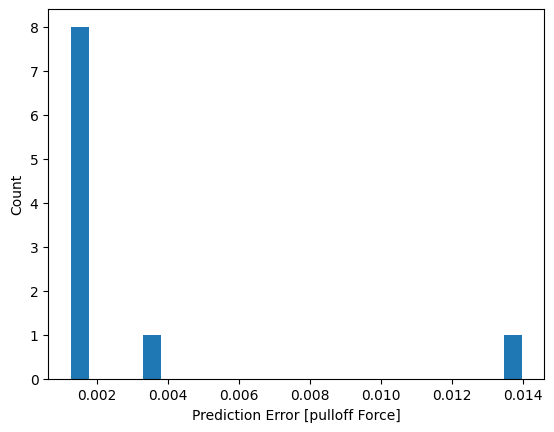

In [13]:
error = abs(test_predictions - test_labels)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')

In [14]:
test_rsme = tf.math.sqrt(keras.losses.mean_squared_error(test_labels, test_predictions))
test_rsme.numpy()

0.0046853838

In [16]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


INFO:tensorflow:Assets written to: dnn_model/assets
